# Stock Price Prediction 

In [100]:
(solving the wrong problem!) MARCOS FETURES

SyntaxError: invalid syntax (<ipython-input-100-9a58aa2f05fd>, line 1)

# I) Description of the problem

### On the problem.

* The problem of stock prediction concerns of being able to forecast a *Weakly Non stationary Time Series* so one can **sell** an active at a higher **Ask Price** that is was it's **Bid price** (buying at a smaller price than it was previously sold).


### On the properties of the data.

* Stocks, ETF's, hedge funds, can be modeled instantaneously as two Weakly Non stationary Time Series, one for *bid* prices and one for *ask* prices. By weakly Non stationary Time Series ($X(t)$), it is meant:

<center>First momentum invariance.</center>
$$E[X(t)] = E[X(t + \epsilon)]$$ <br/>

<center>Second momentum invariance.</center>
$$C(X(t)) = C(X(t + \alpha)) = E[(X(t) - E[X(t)])(X(t + \epsilon) - E[X(t + \epsilon)])]$$ <br/>
<center>Bounded energy.</center>
$$E[|X(t)|^2] < \infty $$ <br/>




* So, one should interpret this data as not predictable for longer distances but, among several, one can depicts a few techniques to be able to predict those series. Namely:

    - Short term predictions: It transforms a non-stationary series in a locally stationary series. Thus, predictable.
    - Using the first order derivative ($r(t) = (x(t) - x(t - 1))$): It erases the 'memory' of a non-stationary series. This is also called **RETURNS** of a financial time series.


### On the financial data.

* **Bid's** and **Ask's** are updated at every new *order* in the *order book*, this is called *tick*. For visual chartists, analyzing this *tick* data is too cumbersome, so one of **many** ways of visualizing it, is in the form of **Open, Close, High, Low**, henceforth, nicknamed after *OCHL*. Those are defined as:

![title](assets/ochl.png)


* Among those who do trade stocks, we can find the ones so called *Scalpers* and the *Swing traders*, where, respectively, one places its buy/sell orders in the same day whereas the other waits for several days. We will be dealing with the former.

# II) Loading data

In [1]:
import requests
import quandl
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
api_key = os.environ['QUANDL_API_KEY']
metadata_filename = 'WIKI_metadata.csv'
dataset_filename = 'WIKI_dataset.csv'
dates_range = ['2010-12-31', '2017-12-31']

## Downloading and extracting the dataset

In [3]:
import zipfile
def get_data(url, filename, extract=True):
    r = requests.get(url, allow_redirects=True)
    filename = filename + '.zip' if extract else filename
    open(filename, 'wb').write(r.content)
    if not extract: return
    zipfile.ZipFile(filename, 'r').extractall('./')

In [4]:
get_data('https://www.quandl.com/api/v3/databases/WIKI/metadata?api_key=%s' % api_key, 
         metadata_filename)

get_data('https://www.quandl.com/api/v3/datatables/WIKI/PRICES/delta.json?api_key=%s' % api_key, 
         dataset_filename, extract=False)

In [5]:
metadata_df = pd.read_csv(metadata_filename)
dataset_df = pd.read_csv(dataset_filename)

In [33]:
metadata_df.sample(10)

,code,name,description,refreshed_at,from_date,to_date
2308,PSEM,"Pericom Semiconductor Corp. (PSEM) Prices, Div...","<p>End of day open, high, low, close and volum...",2017-04-26 14:11:54,1997-10-31,2015-11-24
1381,HPE,"Hewlett Packard Enterprise Co (HPE) Prices, Di...",This dataset has no description.,2018-03-27 21:46:11,2015-11-02,2018-03-27
2753,TCBK,"TriCo Bancshares (Chico CA) (TCBK) Prices, Div...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:05,1993-04-20,2018-03-27
1129,FR,First Industrial Realty Trust Inc. (FR) Prices...,"<p>End of day open, high, low, close and volum...",2018-03-27 21:46:08,1994-06-24,2018-03-27
1935,NADL,"North Atlantic Drilling Ltd (NADL) Prices, Div...","<p>End of day open, high, low, close and volum...",2017-09-12 21:47:57,2014-01-29,2017-09-12
532,CENX,"Century Aluminum Company (CENX) Prices, Divide...","<p>End of day open, high, low, close and volum...",2018-03-27 21:45:56,1996-03-29,2018-03-27
1402,HST,"Host Hotels & Resorts Inc (HST) Prices, Divide...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:11,1983-04-06,2018-03-27
1271,GSOL,"Global Sources Ltd. (GSOL) Prices, Dividends, ...","<p>End of day open, high, low, close and volum...",2017-08-28 21:46:34,2000-04-17,2017-08-28
2872,TTEK,"Tetra Tech Inc. (TTEK) Prices, Dividends, Spli...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:05,1991-12-17,2018-03-27
594,CLI,"Mack Cali Realty Corp (CLI) Prices, Dividends,...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:07,1994-08-25,2018-03-27


In [7]:
dataset_df

,"{""data"":{""files"":[]",latest_full_data:null}}


* Since the api for `get`'ing seems to be not working, we can use the **quandl** module to download the dataset.



* The WIKI dataset has a huge variety of stocks and assets, so, we'll be dealing with just **four**. 'CENX', 'TSLA', 'QCOM', 'DPS'.


* We will be dealing with multiple assets only when building a portfolio for hedging assets.


* Also, for the sake of implementation, only two years of data will be downloaded and loaded into memory. Later we can experiment with multiple timeframes for cross validation of models.

In [34]:
quandl.ApiConfig.api_key = api_key

dataset_df = quandl.get_table('WIKI/PRICES', ticker = ['CENX', 'TSLA', 'QCOM', 'DPS'], 
                        date = {'gte': dates_range[0], 'lte': dates_range[1]},
                        paginate=True)
dataset_df.head()
dataset_df.set_index('date', inplace=True, drop=True)

## Peaking on the data

In [37]:
from pandas.plotting import register_matplotlib_converters
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

data_to_plot = dataset_df[dataset_df.ticker == 'CENX'][['open', 'high', 'low', 'close']].copy()
data_to_plot['date'] = data_to_plot.index.map(mdates.date2num).copy()

<IPython.core.display.Javascript object>


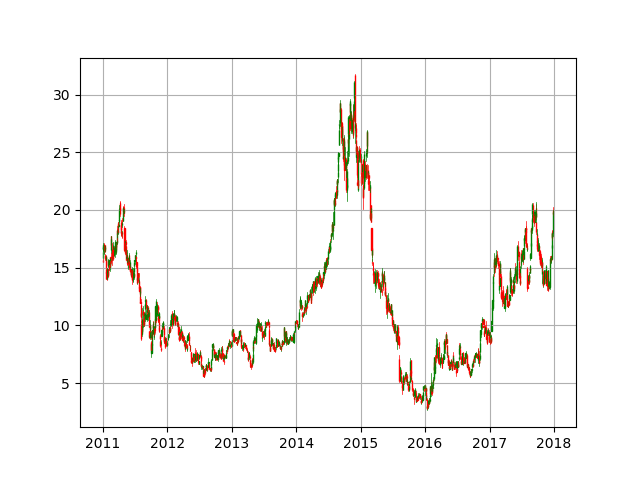

In [39]:
plt.figure(figsize=(16, 6))
ax = plt.subplot()
candlestick_ohlc(ax, data_to_plot[['date', 'open', 'high', 'low', 'close']].values, width=.5, colorup='g', colordown='r')
ax.xaxis_date()
ax.grid()
plt.show()

del data_to_plot

## Train, Validation and test split

* A **true** train/val/test split is one with no **leakage** to/from train/validation/test. 


* So ideally, the test should be another symbol (*e.g.*: train with **Tesla**, validate in another period of time using another asset). 


* But this would only prove the robustness and generalization of our model, while possibly, not maximizing profits in a single asset. Besides, multiple asset analysis is better done using a **Modern Portfolio Theory** (MPT, as proposed by *Markowitz*). 


* Thus, the split will be done in order to only avoid **lookahead bias** (train with day 1 and day 3, and test with day 2).

![title](assets/cross_validation.png)

In [213]:
TRAIN_VAL_PERCENTAGE = 0.85
TEST_PERCENTAGE = 1 - TRAIN_VAL_PERCENTAGE

full_dates_range = pd.date_range(start=dates_range[0], end=dates_range[1]).sort_values()

train_val_date_range = full_dates_range[:int(len(full_dates_range) * TRAIN_VAL_PERCENTAGE)].sort_values()
test_date_range = pd.DatetimeIndex(set(full_dates_range) - set(train_val_date_range)).sort_values()

In [214]:
dataset_df.loc[dataset_df.index.isin(train_val_date_range), 'set'] = 'TRAIN_VAL'
dataset_df.loc[dataset_df.index.isin(test_date_range), 'set'] = 'TEST'

In [215]:
from sklearn.model_selection import TimeSeriesSplit
cross_validation_split = TimeSeriesSplit(n_splits=4)

# III) Feature engineering

* As discussed in the first section, it is useful to transform the OCHL features to something manageable mathematically, such as, a (locally) stationary time series.


In [217]:
features_df = dataset_df[['open', 'high', 'low', 'close', 'volume', 'ticker']].copy()

## Analytical features

### Daily returns.

* One can use the relative returns of one single day as feature, since it is a first order derivative, thus, conveying stationarity to out time series.

$$\frac{X(t_{close})}{X(t_{open})} - 1$$

In [219]:
features_df['daily_returns'] = (features_df.close / features_df.open) - 1

### Log returns.

* Among the advantages explored in the **section I)** of using returns instead of the raw data, we can further improve the feature of time series so it displays desirable statistical properties. One usual transform is known as **Log-returns**, defined as follows:


$$log(\frac{X(t)}{X(t-1)})$$


* The desirable properties of using log-returns can be summed in as being prone to follow a normal distribution and being able to "accumulate" returns over time with simple additions instead of multiplications)

In [222]:
def log_returns(dataframe):
    sorted_dataframe = dataframe.sort_index()
    sorted_dataframe['log_returns'] = np.log(sorted_dataframe.close / sorted_dataframe.close.shift(1))
    return sorted_dataframe
    
features_df = features_df.groupby('ticker')\
    .apply(log_returns).droplevel(0).reset_index(drop=True)

## Market Features (Techinical indicators)

* For traders who are used to manually trade, It's often used a common analysis called **Technical Analysis**, in which allegedly, it is possible to infer market movements such as *momentum*, *overbought*, *oversold*, *breakout break* and *support breakout* through **technical indicators** such as (*e.g.* MACD, RSI, EMA, Bollinger Bands, Stochastic oscillators).



* There are **NO**$^{I}$ proves so far that technical indicators have any real predictive power over the market besides the mere fact that human traders, hedge funds and firms tend to use them, so, by the efficient market hypothesis, the market will react in accordance with those buyers and sellers.


* Thus, we are going to use one of those indicators because it can at least predict if traders are using it too much or otherwise.




<sup>$^{I}$: *Burton G. Malkiel*, A randon walk down wall street.<sup>

### Price-Volume Trend

* Sharp changes in the price that follows a sharp change in volume usually represents a **resistance** or **support**, meaning that traders will consider the market overbought (or oversold) and start to sell (or buy).


* On Balance Volume (OBV) Is an indicator that simply adds or subtracts the volume from a accumulator depending on the return of the current day.

In [224]:
def on_balance_volume(dataframe):
    sorted_dataframe = dataframe.sort_index()
    previous_row = None
    def _compute_obv_for_row(row):
        nonlocal previous_row
        if previous_row is not None:
            row['obv'] = previous_row['obv'] + row['volume'] if row['close'] > previous_row['close'] else\
                         previous_row['obv'] - row['volume'] if row['close'] < previous_row['close'] else\
                         previous_row['obv']
        else:
            row['obv'] = np.nan
            previous_row = row.copy()
            previous_row['obv'] = .0
        return row

    return sorted_dataframe.apply(_compute_obv_for_row, axis=1)

features_df = features_df.groupby('ticker')\
    .apply(on_balance_volume).reset_index(drop=True)

### Normalization

* In order give no priors to our models, the available features will be normalized by their respective standard deviation in the train years so they have the same *a-priori* importance, since their power will always be 1.

In [226]:
_features_df = features_df[['open', 'high', 'low', 'close', 'volume', 'daily_returns', 'log_returns', 'obv']]
_features_df = _features_df.div(_features_df.std())
features_df[['open', 'high', 'low', 'close', 'volume', 'daily_returns', 'log_returns', 'obv']] = _features_df

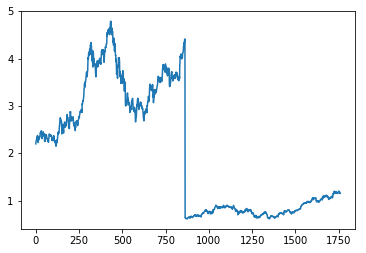

In [231]:
plt.plot(features_df[features_df.ticker == 'AAPL']['close'])

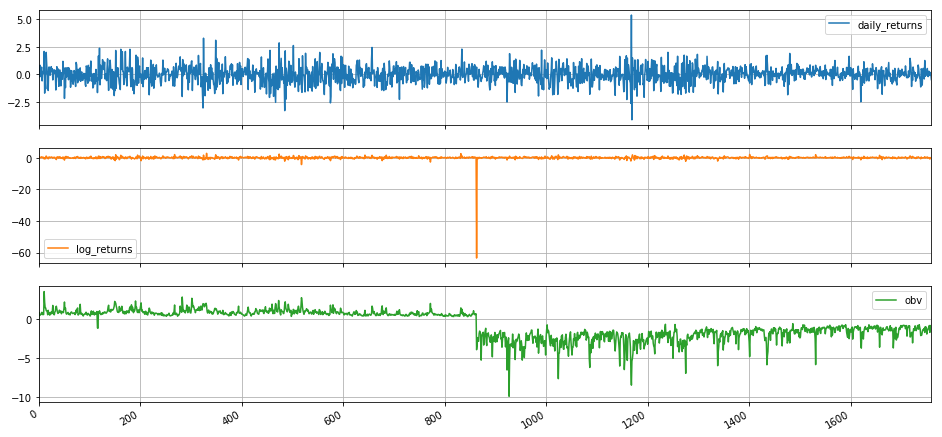

In [229]:
features_df[features_df.ticker == 'AAPL'][['daily_returns', 'log_returns', 'obv']].plot(subplots=True, figsize=(16, 8), grid=True)
plt.show()